In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 

#from category_encoders import CountEncoder # requires separate installation
#from custom_transformers import OurSimpleImputer, OurAdvancedImputer, DataCorrection, DropColumns
#from custom_transformers import GeoClustering, Distance, Interactions, OtherFeatures

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# 0. loading data

In [5]:
original_train_values = pd.read_csv('data/train.csv')
original_train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')
original_train = pd.merge(original_train_values, original_train_labels, on='id')
original_train.date_recorded = pd.to_datetime(original_train.date_recorded)

In [6]:
original_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [7]:
train = original_train.copy()

# 1. Exploratory Data Analysis and Understanding

## 1.1 Data Distribution and Statistics

To begin, we will look at the distribution of the target variable in the train dataset.

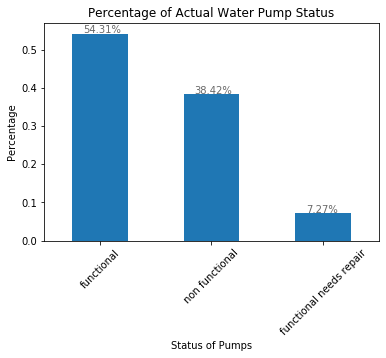

In [8]:
# Bar Plot

# Plot the percentages of actual water pump status'
ax = train['status_group'].value_counts(normalize=True).plot(kind='bar')

# Set title and labels
ax.set_title('Percentage of Actual Water Pump Status')
ax.set_xlabel('Status of Pumps')
ax.set_ylabel('Percentage')
plt.xticks(rotation=45)

# Annotate
totals=[]
for i in ax.patches:
    totals.append(i.get_height())
    
total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x()+.1, i.get_height()+.001,
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=10, color='dimgrey')

As can be seen from the bar plot above, there are much more pumps that are functional and non-functional in our dataset and only a mere 7.27% of our dataset contains pumps that are functional but need repair. This may represent a class-imbalance issue later on when predicting the classes for the test dataset.

Placeholder Column by column stats and distribution

    Correlation matrix:

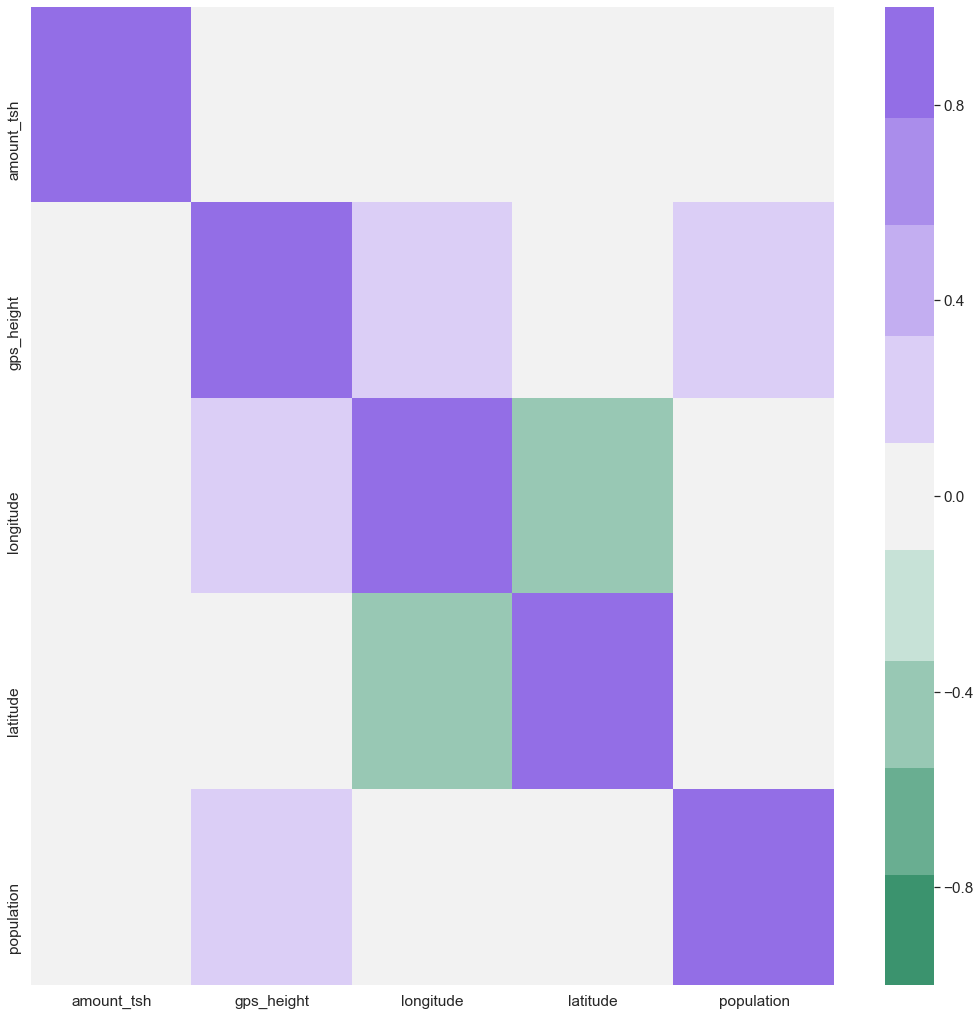

In [47]:
plt.figure(figsize=(18,18))
corr_df = train.corr()

heatmap_df=corr_df.drop(['id','num_private','region_code','district_code','construction_year']).drop(['id','num_private','region_code','district_code','construction_year'],axis=1)

sns.heatmap(heatmap_df,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9)
)

The above correlation matrix shows that the longitude and latidude features are hightly correlated. Population and gps_height are also slightly correlated. 

    Count of Categorical Features:

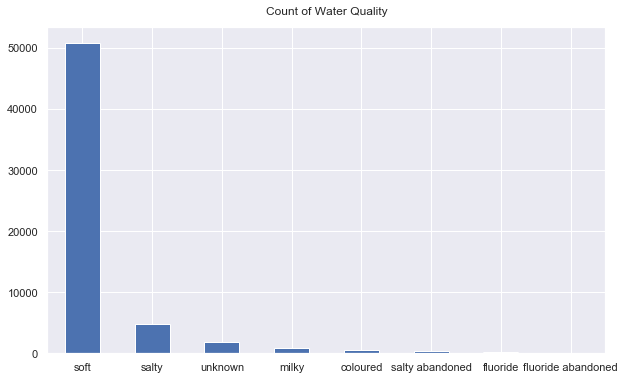

In [10]:
sns.set(font_scale=1)
train['water_quality'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Water Quality", y=1.02);

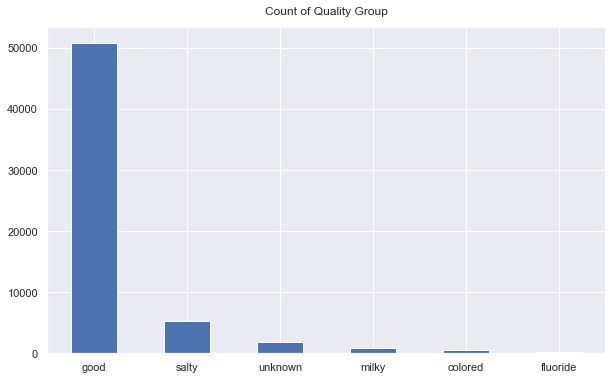

In [11]:
sns.set(font_scale=1)
train['quality_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Quality Group", y=1.02);

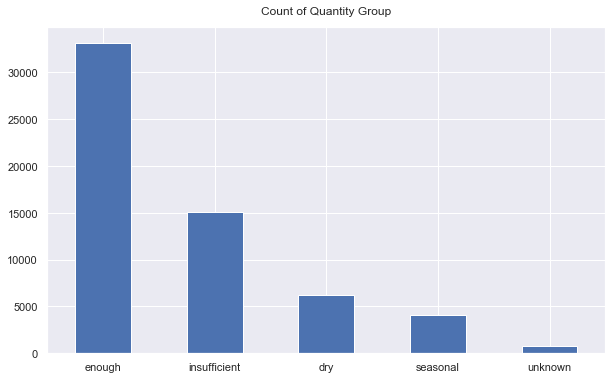

In [12]:
sns.set(font_scale=1)
train['quantity_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Quantity Group", y=1.02);

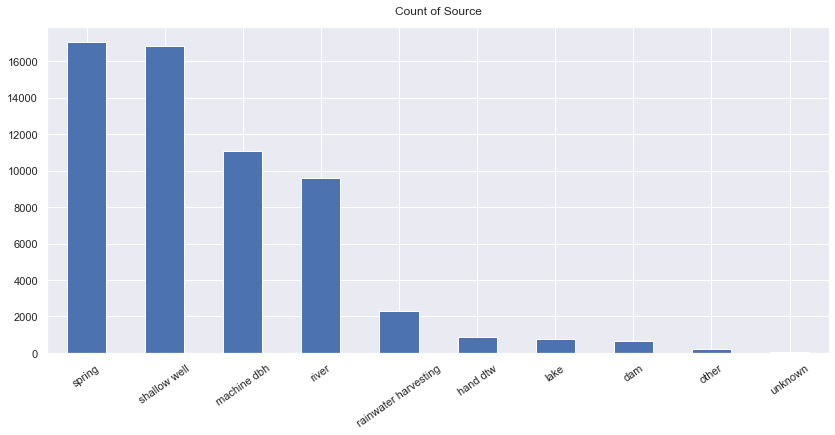

In [13]:
sns.set(font_scale=1)
train['source'].value_counts().plot(kind='bar', figsize=(14, 6), rot=35)
plt.title("Count of Source", y=1.02);

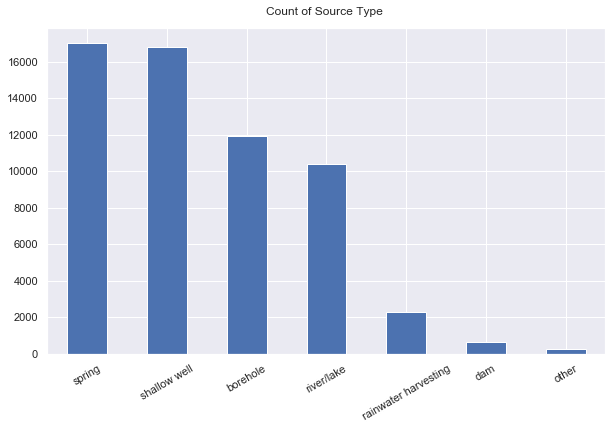

In [14]:
sns.set(font_scale=1)
train['source_type'].value_counts().plot(kind='bar', figsize=(10, 6), rot=30)
plt.title("Count of Source Type ", y=1.02);

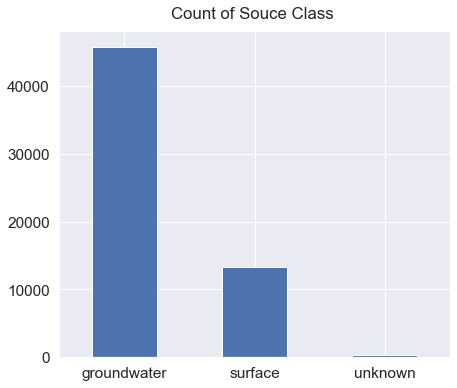

In [15]:
sns.set(font_scale=1.4)
train['source_class'].value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.title("Count of Souce Class ", y=1.02);

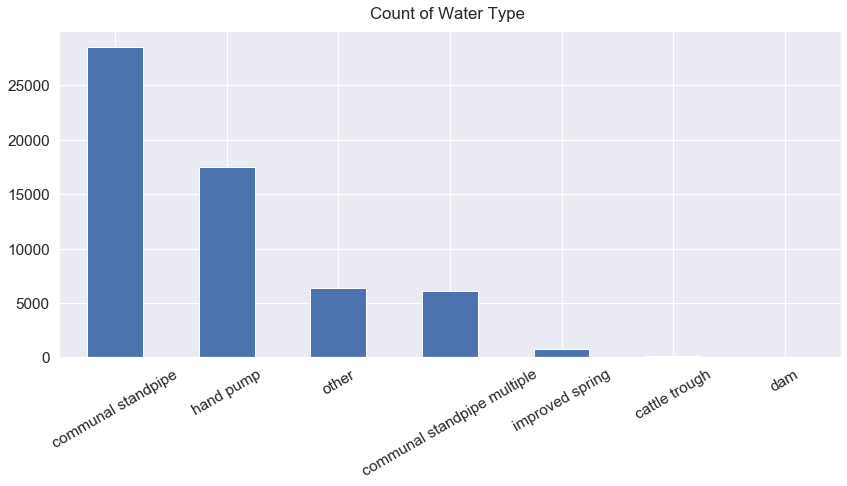

In [16]:
sns.set(font_scale=1.4)
train['waterpoint_type'].value_counts().plot(kind='bar', figsize=(14, 6), rot=30)
plt.title("Count of Water Type ", y=1.02);

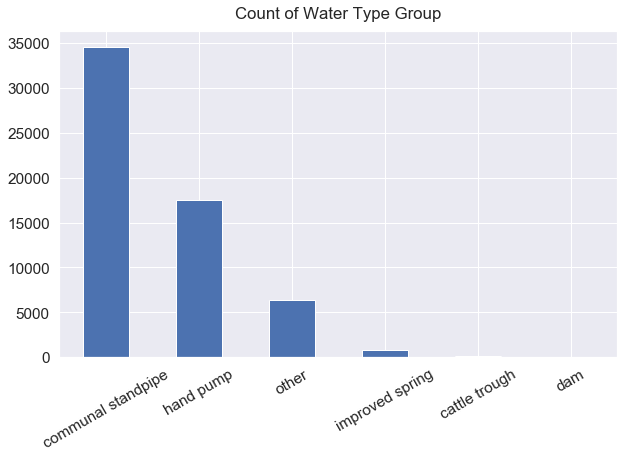

In [17]:
sns.set(font_scale=1.4)
train['waterpoint_type_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=30)
plt.title("Count of Water Type Group", y=1.02);

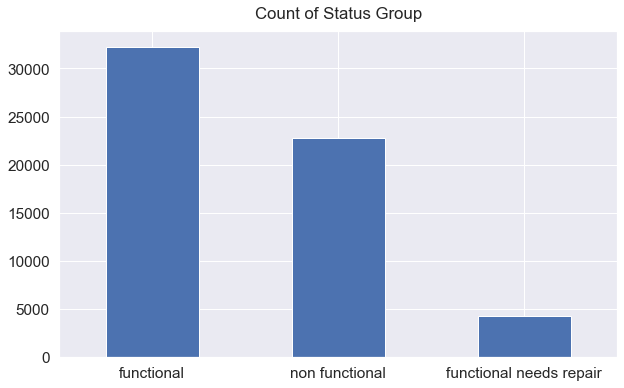

In [18]:
sns.set(font_scale=1.4)
train['status_group'].value_counts().plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Count of Status Group", y=1.02);

In [19]:
train.groupby('lga').count()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
lga,,,,,,,,,,,,,,,,,,,,,
Arusha Rural,1252,1252,1252,1204,1252,1206,1252,1252,1252,1252,...,1252,1252,1252,1252,1252,1252,1252,1252,1252,1252
Arusha Urban,63,63,63,0,63,0,63,63,63,63,...,63,63,63,63,63,63,63,63,63,63
Babati,511,511,511,509,511,509,511,511,511,511,...,511,511,511,511,511,511,511,511,511,511
Bagamoyo,997,997,997,995,997,995,997,997,997,997,...,997,997,997,997,997,997,997,997,997,997
Bahi,224,224,224,220,224,222,224,224,224,224,...,224,224,224,224,224,224,224,224,224,224
Bariadi,1177,1177,1177,1168,1177,1166,1177,1177,1177,1177,...,1177,1177,1177,1177,1177,1177,1177,1177,1177,1177
Biharamulo,403,403,403,403,403,403,403,403,403,403,...,403,403,403,403,403,403,403,403,403,403
Bukoba Rural,487,487,487,486,487,486,487,487,487,487,...,487,487,487,487,487,487,487,487,487,487
Bukoba Urban,88,88,88,0,88,0,88,88,88,88,...,88,88,88,88,88,88,88,88,88,88


## 1.2 Advanced Data Exploration



We first decided to explore the population split by region as it would be useful to know which regions contain the highest populations.

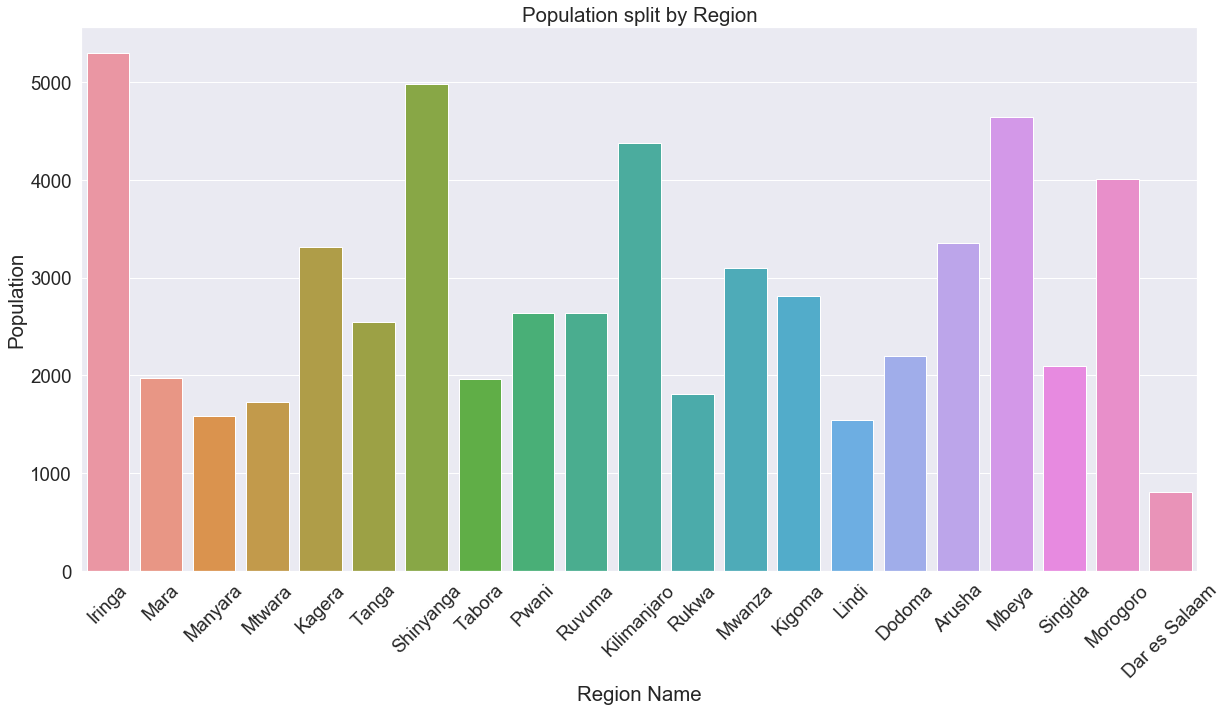

In [18]:
# A bar chart showing the population of each region
df_pop = train.dropna(subset=['region'])
df_pop = train.loc[:, ['region', 'population']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_pop, x='region')

ax.set(xlabel='Region Name', ylabel='Population', title='Population split by Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

This chart gives you an idea of which regions have the highest population. Based on this it would be more interesting to see the functionality of pumps split by region.

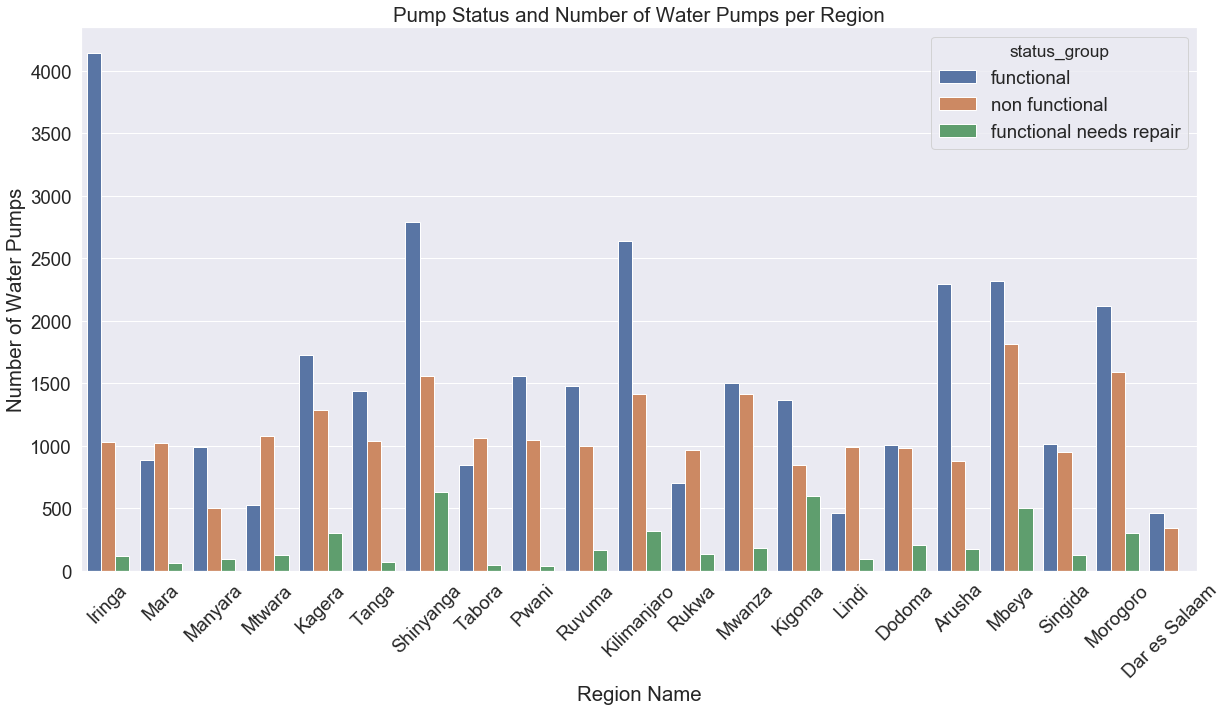

In [19]:
# A bar chart showing the number of each status group by each region
df_region = train.dropna(subset=['region'])
df_region = train.loc[:, ['region', 'status_group']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_region, x='region', hue='status_group')

ax.set(xlabel='Region Name', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Region')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

From the chart above we can see that Dodoma - the official capital and Dar es Salaam - the commercial capital of Tanzania, have comparatively lower number of water pumps for each category of functionality compared to other regions. This could imply that these more developed regions rely on piping and have a generally better water infrastructure and therefore don't require as many water pumps.

Following this, we also wished to look at the functionality of water pumps by Waterpoint Type to see which waterpoint types were more functional than others.

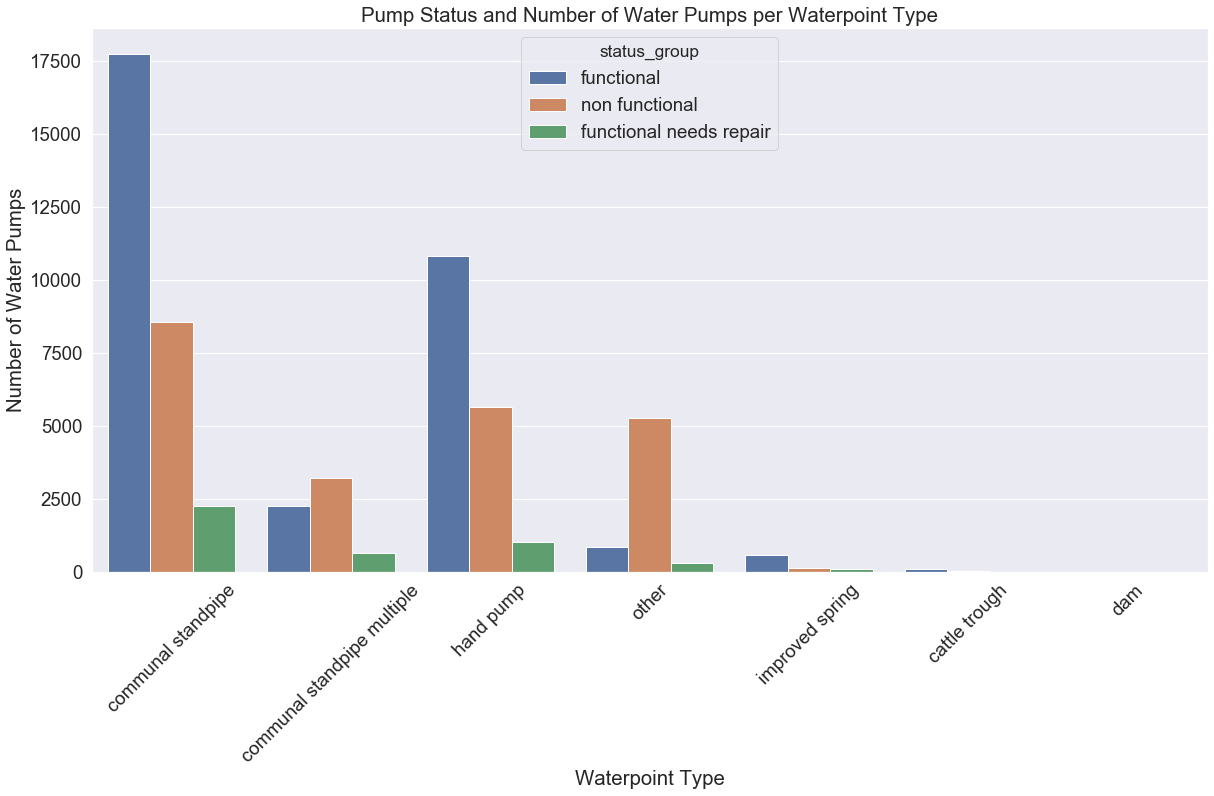

In [20]:
# A bar chart showing the number of each status group by each type of waterpoint type
df_wpt = train.dropna(subset=['waterpoint_type'])
df_wpt = train.loc[:, ['waterpoint_type', 'status_group']]

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data=df_wpt, x='waterpoint_type', hue='status_group')

ax.set(xlabel='Waterpoint Type', ylabel='Number of Water Pumps', title='Pump Status and Number of Water Pumps per Waterpoint Type')

sns.set(font_scale=1.7)
plt.xticks(rotation=45);

As we can see there is a clear majority of one type of waterpoint type which is the communal standpipe.

We also analysed the functionality by the amount_tsh(total amount of water available to a waterpoint).

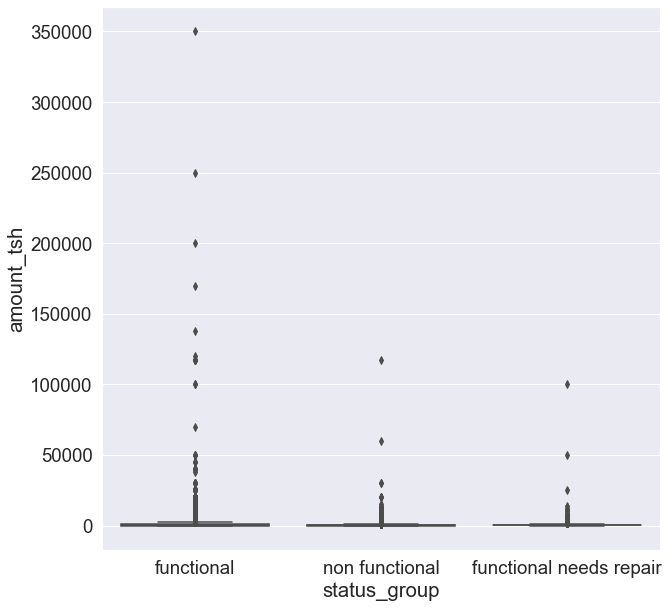

In [61]:
plt.figure(figsize = (10,10))
ax = sns.boxplot(x="status_group", y="amount_tsh", data=train.loc[(train.amount_tsh != 0)])

Plotting the data as is, gives us an idea that the distribution of the data spread across functionality is heavily skewed and uneven due to the large number of outliers.

By filtering our dataset to exclude 0 values as well as only values with an amount_tsh of over 10000, we can zoom into our dataset to get a better idea of the distribution.

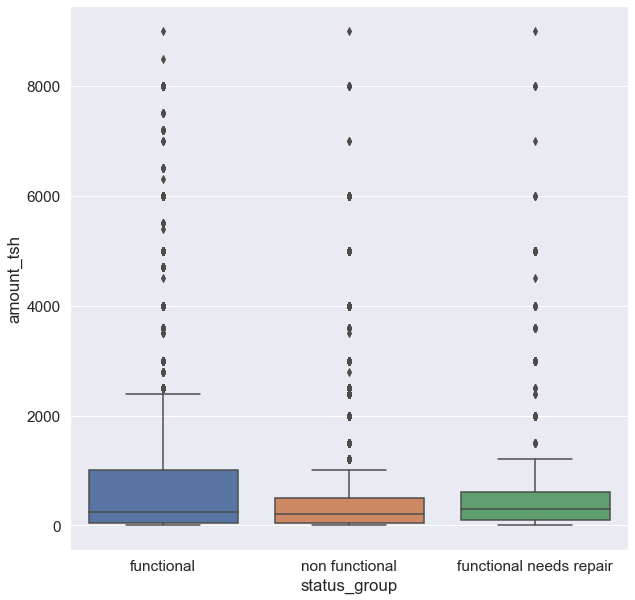

In [29]:
plt.figure(figsize = (10,10))
ax = sns.boxplot(x="status_group", y="amount_tsh", data=train.loc[(train.amount_tsh < 10000) & (train.amount_tsh != 0)])

As we can see from the plot above, the water pumps that are functional have more water and as a result also contain the majority of the outliers.

# 2. Data Preparation and Cleaning 

## 1.1 meaningless features

##### There are few columns that contain the same information but on different granularity level. In each case, we decided to keep columns that have more granular data and in case we needed to group them later, we would be able to do that. Columns in bold are those that we keep:
1. <strong>waterpoint_type</strong> / waterpoint_type_group
2. <strong>source</strong> / source_type / source_class
3. <strong>quantity</strong> / quantity_group
4. <strong>water_quality</strong> / quality_group
5. <strong>payment</strong> / payment_type
6. <strong>management</strong> / management_group
7. <strong>extraction_type</strong> / extraction_type_group / extraction_type_class
8. <strong>scheme_management</strong> / scheme_name
----- 
##### Besides, we decided to drop the following features because they don't contain useful information:
1. <strong>recorded_by</strong>: contains only one value, which is organization that recorded the data
2. <strong>id</strong>: surrogate key, column representing id of the observation in numerical format, doesn't contain any information.
----- 
##### We also decided to drop 4 features related to location (region, district_code, region_code, subvillage) for the following reasons:
1. combination of the features <strong>district_code, region_code</strong> gives us zip code which identifies the location, but we can get the same information in more detailed way from geograhic coordinates (<strong>longitude, latitude</strong>)
2. we have feature <strong>lga</strong> that contains similar information to <strong>region_code, region</strong> but on more granular level
3. we will use <strong>latitude</strong> and <strong>longitude</strong> for creating clusters of regions with more granularity, therefore, we can drop <strong>subvillage</strong> too
----- 
##### We are dropping <strong>public_meeting</strong> too for two reasons:
1. 86% of values are the same
2. According to research on water issue in Tanzania, public meeting at installation is not good predictor

In [ ]:
columns_to_drop = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

## 1.2 missing values

#### features with various names for missing value
The dataset is quite dirty in a sense that missing values are represented in various forms:
1. simply NaN / missing cells
2. contains value "unknown", "Not known", "not known", "-", "No", "no", "0", "unknown", "none".

We tried to find those values that might represent missing value in each column and standardize them by replacing all those columns with "unknown"

In [ ]:
train = OurSimpleImputer(coords=False).fit_transform(train)

#### construction_year
This feature contains value of 0, which indicates missing value

#### amount_tsh
This feature contains value of 0, which indicates missing value

#### longitude and latitude
After checking longitude and latitude, we found that we have some of the values to be 0. Given that this is Tanzania, latitude and longitude of 0 or close to 0 are simply impossible. We decided to replace those values with mean for each LGA, which has quite detailed granularity (125 LGAs).

In [ ]:
train = OurSimpleImputer(categorical=False).fit_transform(train)

#### population
Almost 48% of observations have value "population" equal to 0 or 1. According to the description, this feature indicates the population around the particular waterpoint. It is hard to believe that the waterpoint was built for 0 or 1 person. Hence, we believe these two values indicate missing values or incorrect recording. We initially wanted to take population from other dataset and merge it with this one, however, the definition of population feature in this dataset is slightly different. Given that this is a population <strong>around</strong> a particular waterpoint, we decided to use population average of each coordinates-based cluster to impute missing values. 

(Seems like 50 is good number of K-Means clusters)

In [ ]:
locations = train[['latitude','longitude']]
locations_transformed = StandardScaler().fit_transform(locations)

n_clusters = [10, 20, 30, 40, 60, 80, 100, 150]
inertia = []

for num in n_clusters:
    kmeans_model = KMeans(n_clusters=num, n_jobs=-1).fit(locations_transformed)
    wss = kmeans_model.inertia_
    inertia.append(wss)
    
pd.DataFrame({'n_clusters':n_clusters, 'inertia': inertia}).plot(x='n_clusters', y='inertia');

In [ ]:
train = Clustering().fit_transform()
train = OurAdvancedImputer().fit_transform()

## 1.3 data correctness

#### Installer and Funder

In [ ]:
train = DataCorrection(installer=True, funder=True).fit_transform(train)

# 2. feature engineering

Ideas:
1. Clustering based on lat/lon
2. Distance to centers (manhattan and eucledian)
3. Bucketization for population
4. Interactions
    1. scheme_management + payment
    2. basin + source
    3. source + waterpoint_type
    4. extraction_type + waterpoint_type
    5. source + extraction_type
    6. water_quality + quantity
    7. extaction_type + payment
5. Month from date_recorded
6. Replace num_private to True/False
7. CountEncoder only: funder, installer, wpt_name, lga, ward
8. 1Hot / CountEncoder: basin(9), scheme_management(13), management(12), source(10), payment(7), extraction_type(18), waterpoint_type(7), water_quality(8), quantity(5)
9. Construction year and amount_tsh?


In [9]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'construction_year', 'num_private']

transformation_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer(permit=False)),
    ('government', DataCorrection(installer=True, funder=True)),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer(population_bucket=False)),
    ('distance', Distance()),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures(num_private=False)),
    ('drop', DropColumns(features_to_drop))
])

In [10]:
train_prep = transformation_pipeline.fit_transform(original_train)

# 3. feature selection

## 3.1 information gain

In [6]:
def information_gain(df, feature, target):
    p_target = df[target].value_counts(normalize=True)
    H_target = np.nansum(-np.log2(p_target) * p_target)
    
    p_feature_target = df.groupby(feature)[target].value_counts(normalize=True)
    p_features = df[feature].value_counts(normalize=True)
    
    H_feature = 0
    for value in df[feature].unique():
        H_value = p_features[value] * np.nansum(-np.log2(p_feature_target[value]) * p_feature_target[value])
        H_feature += H_value
    
    return H_target - H_feature 

In [11]:
features = train_prep.columns.drop('status_group')
information_gain_features = {}
for feature in features:
    information_gain_features[feature] = information_gain(train_prep, feature, 'status_group')
sorted(information_gain_features.items(), key=lambda tup: -tup[1])    

[('distance_to_Dodoma', 1.242184389456188),
 ('distance_to_Salaam', 1.242184389456188),
 ('wpt_name', 0.8612901168935635),
 ('type_wpt_name', 0.3594386288468353),
 ('ward', 0.30954287706550687),
 ('water_quality_quantity', 0.15857861448678623),
 ('quantity', 0.15094320741407263),
 ('funder', 0.1482465506328099),
 ('extraction_type_payment', 0.14542904012412627),
 ('installer', 0.14267921577366205),
 ('water_per_capita', 0.1408250304644465),
 ('lga', 0.13328413547688234),
 ('source_waterpoint_type', 0.13197846064495367),
 ('extraction_waterpoint_type', 0.12912163343606253),
 ('waterpoint_type', 0.09231806387508135),
 ('population', 0.09164276732961918),
 ('extraction_type', 0.09021017615614979),
 ('scheme_management_payment', 0.08594661671707748),
 ('gps_height', 0.08585915080455542),
 ('cluster', 0.08039803434778747),
 ('basin_source', 0.07772321902166568),
 ('amount_tsh', 0.053241088064490905),
 ('payment', 0.04951056991934144),
 ('source', 0.03140911757275178),
 ('water_quality', 0.0

#### Notes:
1. permit: if NA are imputed with True, information gain is 0.00083. If with False, then 0.00075. We are dropping this feature.
2. num_private: very low value of 0.00016, we decided to drop this feature
3. population_binned: very low value of 0.00226, we decided not to create this feature in next iteration and pipeline
4. installer: not corrected version of installer gives 0.189, corrected/grouped version gives 0.143
5. funder: not corrected version of installer gives 0.176, corrected/grouped version gives 0.148
6. cluster: k=50 clusters gives 0.084


## 3.2 Logit L1 selection

In [ ]:
X, y = train_prep[train_prep.columns.drop("status_group")], train['status_group']

logistic = LogisticRegression(C=1, penalty="l1", random_state=289).fit(X, y)
feature_selector = SelectFromModel(logistic, prefit=True)

X_new = model.transform(X)
X_new

In [ ]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=X.index,
                                 columns=X.columns)

selected_columns = selected_features.columns[selected_features.var() != 0]

# 4. modeling and evaluation

## 4.1 Full pipeline

In [ ]:
meaningless_cols = ['id','waterpoint_type_group', 'source_type', 'source_class', 
                   'quantity_group', 'quality_group', 'payment_type', 
                   'management_group', 'extraction_type_group', 'extraction_type_class', 
                   'scheme_name', 'recorded_by', 'district_code', 
                   'region_code', 'region','subvillage', 'public_meeting']

features_to_drop = ['latitude', 'longitude', 'date_recorded', 'construction_year']

full_pipeline = Pipeline([
    ('meaningless_features', DropColumns(meaningless_cols)),
    ('simple_imputer', OurSimpleImputer()),
    ('government', DataCorrection()),
    ('geo_clusters', GeoClustering()),
    ('advanced_imputer', OurAdvancedImputer()),
    ('distance', Distance()),
    ('interactions', Interactions()),
    ('other_features', OtherFeatures()),
    ('drop', DropColumns(features_to_drop)),
    ('count_encoder', CountEncoder(handle_unknown=0))
])

In [ ]:
class_to_num = {'functional': 2, 'non functional': 0, 'functional needs repair': 1}
num_to_class = {0:'non functional', 1: 'functional needs repair', 2: 'functional'} 

X = original_train.drop('status_group', axis=1)
y = original_train.status_group.replace(class_to_num)

X_prep = transformation_pipeline.fit_transform(X)

In [ ]:

rf = RandomForestClassifier(n_estimators=50).fit(X_prep,y)

In [ ]:
y_pred = rf.predict(test_prep)
y_pred = y_pred.replace(num_to_class)

In [ ]:
test_id = pd.read_csv('data/test.csv').id
submission = pd.DataFrame({"id": test_id, "status_group": y_pred})
submission = submission.replace({'status_group': num_to_class})
submission.to_csv('submission1.csv', index=False)

In [ ]:
cross_val_score(rf, X_prep, y, cv=5, scoring='accuracy')

In [ ]:
y_pred_cv = cross_val_predict(rf, X_prep, y, cv=5)
conf_mx = confusion_matrix(y, y_pred_cv)
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
norm_conf_mx

In [ ]:
y.value_counts(normalize=True)